In [ ]:
%%capture
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from datetime import datetime
import scipy as sp
!pip install torchsummaryX
from torchsummaryX import summary

In [ ]:
trainData = pd.read_excel("trainData.xlsx")
testData = pd.read_excel("testData.xlsx")
valData = pd.read_excel("valData.xlsx")
print(trainData.head())

     H   slope  cs  phis  cc  phic   pga      R
0   50  26.565   0    15   5    15  0.21  0.335
1  100  26.565   0    15   5    15  0.21  0.345
2  150  26.565   0    15   5    15  0.21  0.355
3   50  21.800   0    15   5    15  0.21  0.332
4  100  21.800   0    15   5    15  0.21  0.342


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

Xtrain = scaler.fit_transform(trainData.values.astype('float64')[:, :-1])
ytrain = trainData['R'].values.astype('float64')

Xval = scaler.transform(valData.values.astype('float64')[:, :-1])
yval = valData['R'].values.astype('float64')

Xtest = scaler.transform(testData.values.astype('float64')[:, :-1])
ytest = testData['R'].values.astype('float64')

In [ ]:
class FullyConnected(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size, device):
    super(FullyConnected, self).__init__()
    self.D = input_size
    self.M = hidden_size
    self.K = output_size
    self.h = torch.nn.Linear(self.D, self.M, device = device)
    self.y = torch.nn.Linear(self.M, self.K, device = device)
    self.device = device
  def forward(self, X):
    out = self.h(X)
    out = torch.nn.functional.relu(out)
    out = torch.nn.functional.dropout(out, p = 0.1)
    out = self.y(out)
    out = torch.nn.functional.relu(out)
    return  out

In [ ]:
def training_loop(hidden_size, Xtrain, ytrain, Xtest, ytest, Xval, yval, id):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)
  model = FullyConnected(input_size = 7,
                        hidden_size = hidden_size,
                        output_size = 1,
                        device = device)
  summary(model, torch.zeros((1, 7), device = device))

  optimizer = torch.optim.Adam(model.parameters())
  criterion = torch.nn.MSELoss()

  n_epochs = 1001
  train_losses = []
  val_losses = []
  #training loop
  for it in range(n_epochs):
    t0 = datetime.now()
    optimizer.zero_grad()
    rndperm = np.random.permutation(range(Xtrain.shape[0]))
    inputs = torch.Tensor(Xtrain[rndperm, :]).to(device)
    target = torch.Tensor(ytrain[rndperm]).to(device).view(-1, 1)
    pred = model(inputs)
    loss = criterion(pred, target)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # validation
    with torch.no_grad():
      rndperm = np.random.permutation(range(Xval.shape[0]))
      inputs = torch.Tensor(Xval[rndperm, :]).to(device)
      target = torch.Tensor(yval[rndperm]).to(device).view(-1, 1)
      pred = model(inputs)
      loss = criterion(pred, target)
      val_losses.append(loss.item())

    if it % 100 == 0:
      t1 = datetime.now()
      print(f'Epoch: {it} Train Loss: {train_losses[it]:.3f} \
              Validation Loss: {val_losses[it]:.3f} Elapsed: {t1 - t0}s')

  with torch.no_grad():
    inputs = torch.Tensor(Xtest).to(device)
    target = torch.Tensor(ytest).to(device).view(-1, 1)
    pred = model(inputs)
    loss = criterion(pred, target)
    print(f'Test Loss: {loss.item():.3f}')
    pred = pred.cpu().view(-1).numpy()
    target = target.view(-1).cpu().numpy()
    r, p = sp.stats.pearsonr(pred, target)
    p = f'p = {p:.3f}' if p >= 0.005 else 'p < 0.005'
    print(f'R = {r:.3f}, {p}')
    plt.scatter(target, pred, c='black', marker='.', s=100)
    plt.plot([target.min(), target.max()], [pred.min(), pred.max()], color = 'red', linewidth = 2)
    plt.title(f'R = {r:.3f} and {p} for h = {hidden_size}')
    plt.xlabel('True Value')
    plt.ylabel('Prediction Value')
    plt.savefig(f'Model{hidden_size}Correlation{id}.png', dpi = 300, format = 'png')
    plt.show()

  plt.plot(range(n_epochs), train_losses, color = 'black', linewidth = 2)
  plt.plot(range(n_epochs), val_losses, color = 'gray', linewidth = 2, linestyle = 'dashed', alpha = 0.8)
  plt.xlabel('Epochs')
  plt.ylabel('MSE Loss')
  plt.title(f'Training and Validation Learning Curve for h = {hidden_size}')
  plt.savefig(f'Model{hidden_size}Learning{id}.png', dpi = 300, format = 'png')
  plt.show()
  return model, loss.item()

cuda


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 10]      [1, 10]      80         70
1_y        [10, 1]       [1, 1]      11         10
--------------------------------------------------
                      Totals
Total params              91
Trainable params          91
Non-trainable params       0
Mult-Adds                 80
Epoch: 0 Train Loss: 1.596               Validation Loss: 1.971 Elapsed: 0:00:00.024168s
Epoch: 100 Train Loss: 0.653               Validation Loss: 0.988 Elapsed: 0:00:00.002283s
Epoch: 200 Train Loss: 0.566               Validation Loss: 0.858 Elapsed: 0:00:00.010545s
Epoch: 300 Train Loss: 0.421               Validation Loss: 0.771 Elapsed: 0:00:00.002358s
Epoch: 400 Train Loss: 0.377               Validation Loss: 0.549 Elapsed: 0:00:00.007204s
Epoch: 500 Train Loss: 0.228               Validation Loss: 0.307 Elapsed: 0:00:00.004692s
Epoch: 600 Train Loss: 0.151               Validation Lo

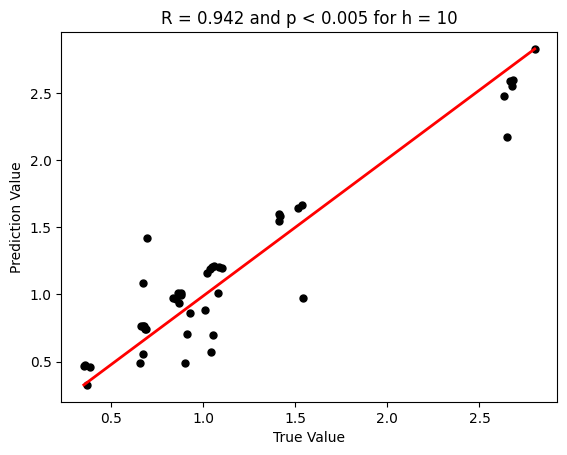

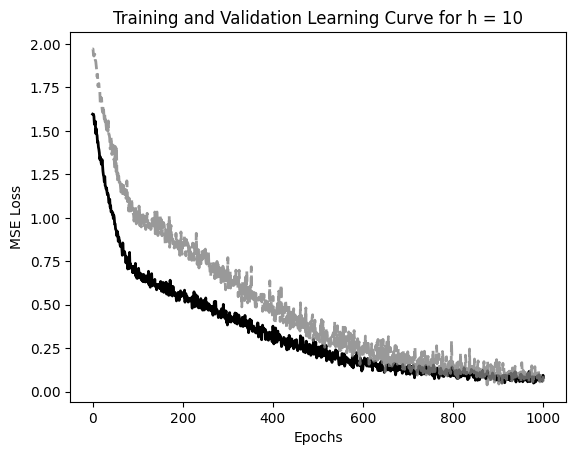

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 10]      [1, 10]      80         70
1_y        [10, 1]       [1, 1]      11         10
--------------------------------------------------
                      Totals
Total params              91
Trainable params          91
Non-trainable params       0
Mult-Adds                 80
Epoch: 0 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.003815s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001849s
Epoch: 200 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001856s
Epoch: 300 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001819s
Epoch: 400 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001883s
Epoch: 500 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002405s
Epoch: 600 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001779s
Epoch: 700 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001928s
Epoch: 800 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001865s
Epoch: 900 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001767s
Epoch: 1000 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002252s
Test Loss: 1.765
R = nan, p < 0.005


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


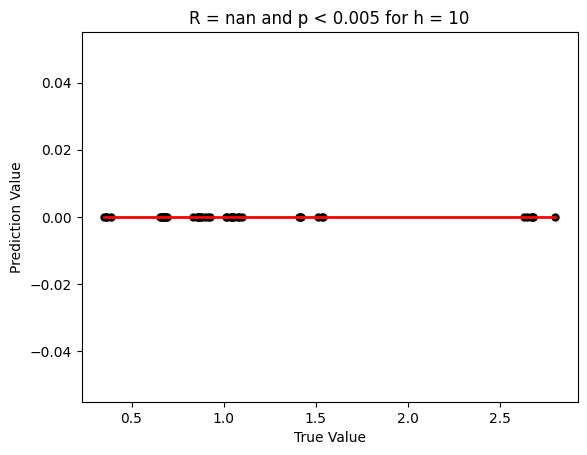

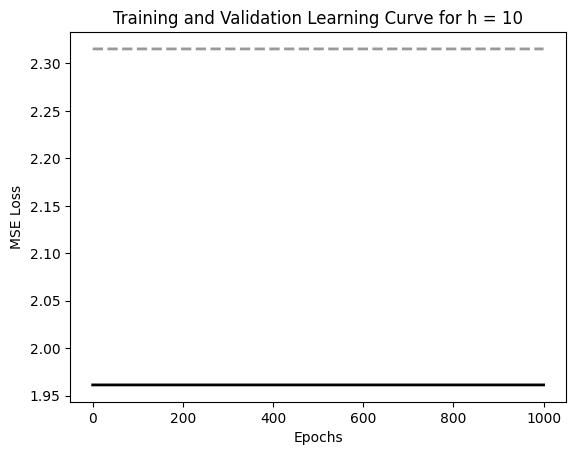

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 10]      [1, 10]      80         70
1_y        [10, 1]       [1, 1]      11         10
--------------------------------------------------
                      Totals
Total params              91
Trainable params          91
Non-trainable params       0
Mult-Adds                 80
Epoch: 0 Train Loss: 1.771               Validation Loss: 2.037 Elapsed: 0:00:00.005206s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.655               Validation Loss: 0.941 Elapsed: 0:00:00.001954s
Epoch: 200 Train Loss: 0.392               Validation Loss: 0.646 Elapsed: 0:00:00.001978s
Epoch: 300 Train Loss: 0.327               Validation Loss: 0.442 Elapsed: 0:00:00.002674s
Epoch: 400 Train Loss: 0.217               Validation Loss: 0.249 Elapsed: 0:00:00.001784s
Epoch: 500 Train Loss: 0.145               Validation Loss: 0.132 Elapsed: 0:00:00.004086s
Epoch: 600 Train Loss: 0.095               Validation Loss: 0.132 Elapsed: 0:00:00.003085s
Epoch: 700 Train Loss: 0.050               Validation Loss: 0.075 Elapsed: 0:00:00.002644s
Epoch: 800 Train Loss: 0.048               Validation Loss: 0.026 Elapsed: 0:00:00.001927s
Epoch: 900 Train Loss: 0.031               Validation Loss: 0.030 Elapsed: 0:00:00.001872s
Epoch: 1000 Train Loss: 0.021               Validation Loss: 0.046 Elapsed: 0:00:00.001831s
Test Loss: 0.029
R = 0.970, p < 0.005


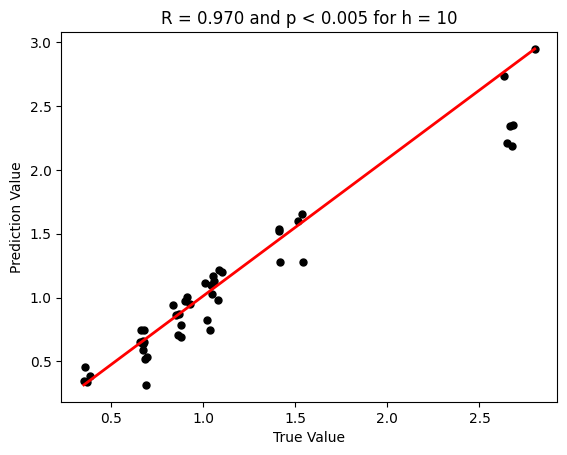

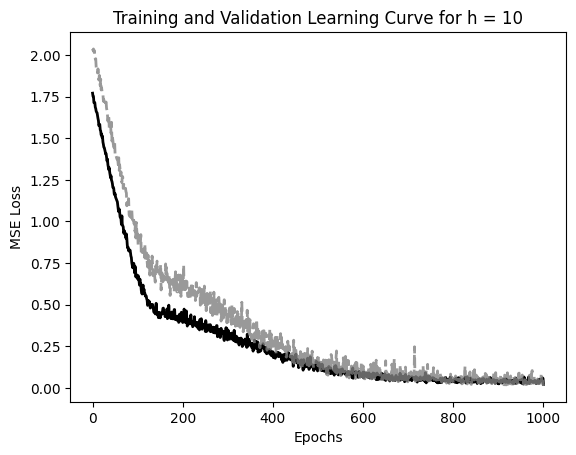

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 10]      [1, 10]      80         70
1_y        [10, 1]       [1, 1]      11         10
--------------------------------------------------
                      Totals
Total params              91
Trainable params          91
Non-trainable params       0
Mult-Adds                 80
Epoch: 0 Train Loss: 1.063               Validation Loss: 1.355 Elapsed: 0:00:00.003039s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.493               Validation Loss: 0.795 Elapsed: 0:00:00.002268s
Epoch: 200 Train Loss: 0.410               Validation Loss: 0.601 Elapsed: 0:00:00.002424s
Epoch: 300 Train Loss: 0.304               Validation Loss: 0.395 Elapsed: 0:00:00.002134s
Epoch: 400 Train Loss: 0.165               Validation Loss: 0.323 Elapsed: 0:00:00.002209s
Epoch: 500 Train Loss: 0.138               Validation Loss: 0.175 Elapsed: 0:00:00.002258s
Epoch: 600 Train Loss: 0.067               Validation Loss: 0.106 Elapsed: 0:00:00.002302s
Epoch: 700 Train Loss: 0.075               Validation Loss: 0.116 Elapsed: 0:00:00.002239s
Epoch: 800 Train Loss: 0.058               Validation Loss: 0.067 Elapsed: 0:00:00.002232s
Epoch: 900 Train Loss: 0.061               Validation Loss: 0.070 Elapsed: 0:00:00.002600s
Epoch: 1000 Train Loss: 0.052               Validation Loss: 0.068 Elapsed: 0:00:00.005293s
Test Loss: 0.068
R = 0.927, p < 0.005


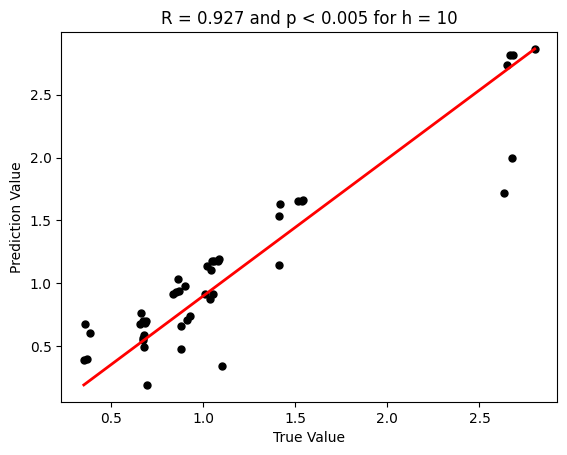

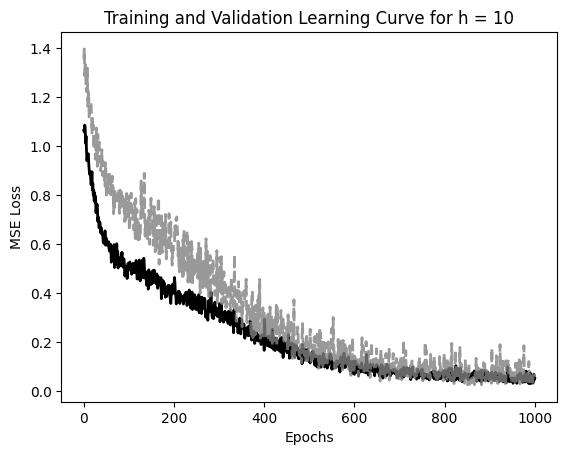

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 10]      [1, 10]      80         70
1_y        [10, 1]       [1, 1]      11         10
--------------------------------------------------
                      Totals
Total params              91
Trainable params          91
Non-trainable params       0
Mult-Adds                 80
Epoch: 0 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.003653s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.003377s
Epoch: 200 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002535s
Epoch: 300 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002002s
Epoch: 400 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001871s
Epoch: 500 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001883s
Epoch: 600 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.005341s
Epoch: 700 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001849s
Epoch: 800 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.005232s
Epoch: 900 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001802s
Epoch: 1000 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001840s
Test Loss: 1.765
R = nan, p < 0.005


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


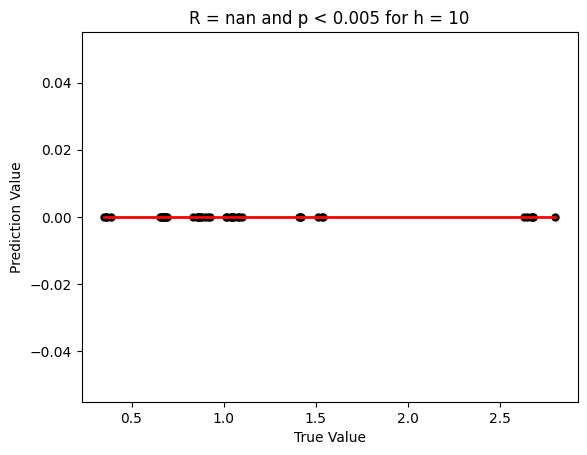

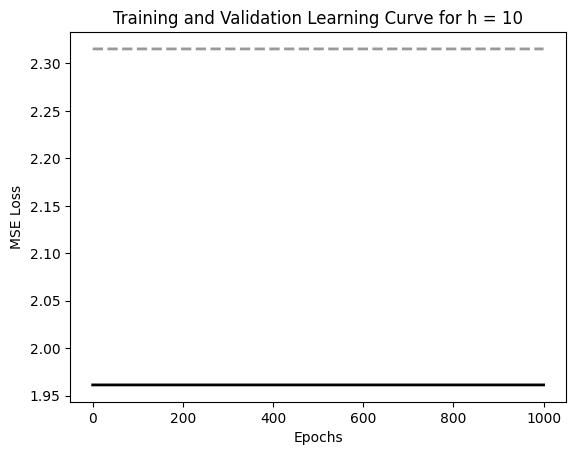

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 20]      [1, 20]     160        140
1_y        [20, 1]       [1, 1]      21         20
--------------------------------------------------
                      Totals
Total params             181
Trainable params         181
Non-trainable params       0
Mult-Adds                160
Epoch: 0 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002826s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002396s
Epoch: 200 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001787s
Epoch: 300 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001883s
Epoch: 400 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002009s
Epoch: 500 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001730s
Epoch: 600 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001887s
Epoch: 700 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002332s
Epoch: 800 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001865s
Epoch: 900 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001787s
Epoch: 1000 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.001952s
Test Loss: 1.765
R = nan, p < 0.005


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


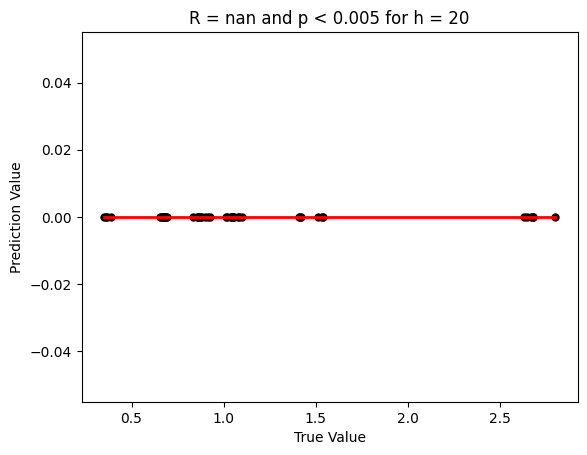

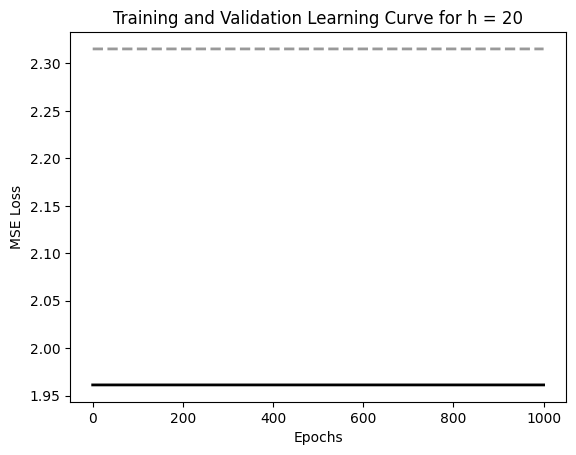

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 20]      [1, 20]     160        140
1_y        [20, 1]       [1, 1]      21         20
--------------------------------------------------
                      Totals
Total params             181
Trainable params         181
Non-trainable params       0
Mult-Adds                160
Epoch: 0 Train Loss: 1.879               Validation Loss: 2.242 Elapsed: 0:00:00.002852s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.469               Validation Loss: 0.732 Elapsed: 0:00:00.001907s
Epoch: 200 Train Loss: 0.220               Validation Loss: 0.366 Elapsed: 0:00:00.001936s
Epoch: 300 Train Loss: 0.118               Validation Loss: 0.155 Elapsed: 0:00:00.001873s
Epoch: 400 Train Loss: 0.089               Validation Loss: 0.099 Elapsed: 0:00:00.001912s
Epoch: 500 Train Loss: 0.030               Validation Loss: 0.060 Elapsed: 0:00:00.001951s
Epoch: 600 Train Loss: 0.032               Validation Loss: 0.041 Elapsed: 0:00:00.001739s
Epoch: 700 Train Loss: 0.037               Validation Loss: 0.038 Elapsed: 0:00:00.001857s
Epoch: 800 Train Loss: 0.024               Validation Loss: 0.031 Elapsed: 0:00:00.001827s
Epoch: 900 Train Loss: 0.030               Validation Loss: 0.036 Elapsed: 0:00:00.001748s
Epoch: 1000 Train Loss: 0.032               Validation Loss: 0.028 Elapsed: 0:00:00.001892s
Test Loss: 0.034
R = 0.962, p < 0.005


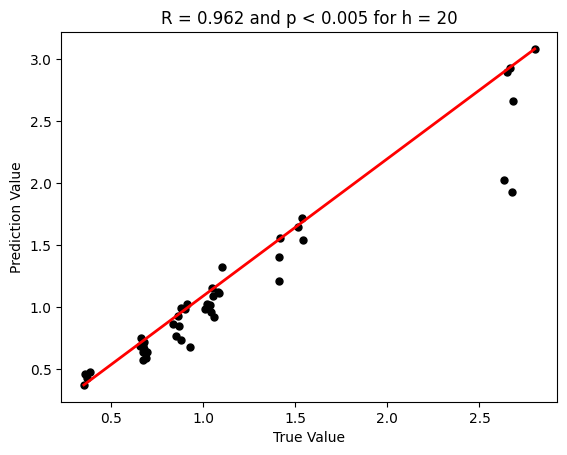

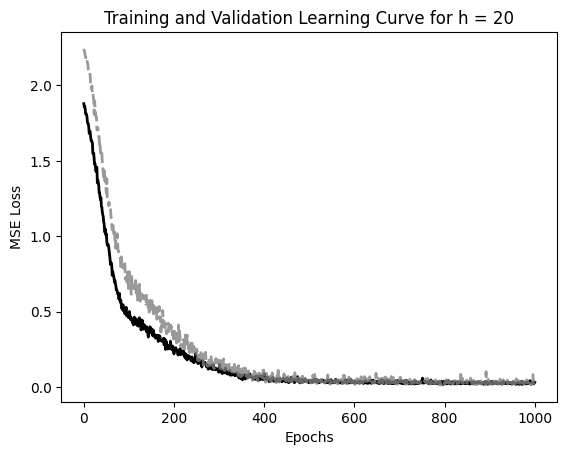

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 20]      [1, 20]     160        140
1_y        [20, 1]       [1, 1]      21         20
--------------------------------------------------
                      Totals
Total params             181
Trainable params         181
Non-trainable params       0
Mult-Adds                160
Epoch: 0 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.005016s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.400               Validation Loss: 0.576 Elapsed: 0:00:00.001924s
Epoch: 200 Train Loss: 0.223               Validation Loss: 0.305 Elapsed: 0:00:00.001852s
Epoch: 300 Train Loss: 0.077               Validation Loss: 0.073 Elapsed: 0:00:00.001837s
Epoch: 400 Train Loss: 0.037               Validation Loss: 0.076 Elapsed: 0:00:00.002041s
Epoch: 500 Train Loss: 0.047               Validation Loss: 0.048 Elapsed: 0:00:00.002277s
Epoch: 600 Train Loss: 0.031               Validation Loss: 0.060 Elapsed: 0:00:00.002364s
Epoch: 700 Train Loss: 0.029               Validation Loss: 0.022 Elapsed: 0:00:00.003146s
Epoch: 800 Train Loss: 0.032               Validation Loss: 0.027 Elapsed: 0:00:00.002298s
Epoch: 900 Train Loss: 0.029               Validation Loss: 0.059 Elapsed: 0:00:00.002556s
Epoch: 1000 Train Loss: 0.021               Validation Loss: 0.031 Elapsed: 0:00:00.002245s
Test Loss: 0.019
R = 0.987, p < 0.005


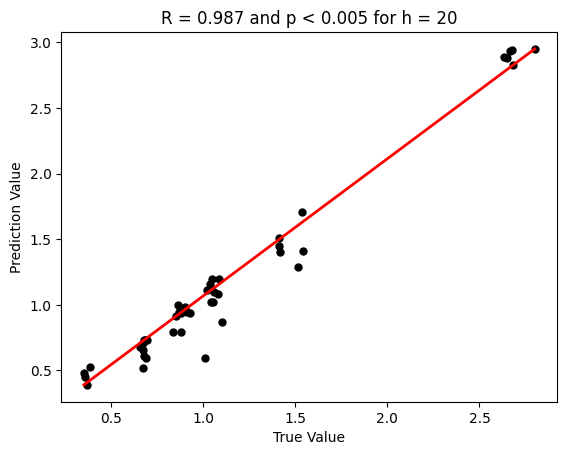

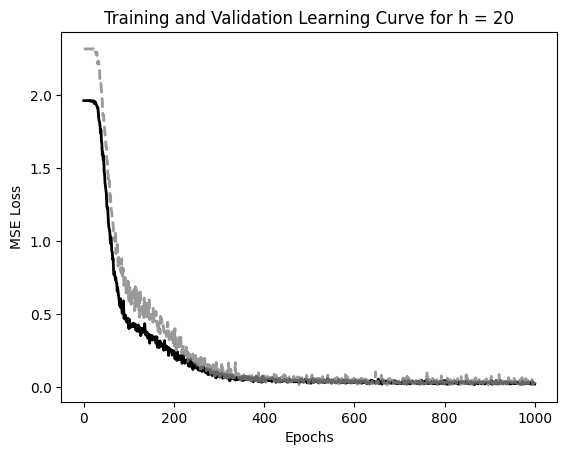

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 20]      [1, 20]     160        140
1_y        [20, 1]       [1, 1]      21         20
--------------------------------------------------
                      Totals
Total params             181
Trainable params         181
Non-trainable params       0
Mult-Adds                160
Epoch: 0 Train Loss: 1.953               Validation Loss: 2.306 Elapsed: 0:00:00.003079s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.486               Validation Loss: 0.725 Elapsed: 0:00:00.002265s
Epoch: 200 Train Loss: 0.202               Validation Loss: 0.278 Elapsed: 0:00:00.002326s
Epoch: 300 Train Loss: 0.091               Validation Loss: 0.133 Elapsed: 0:00:00.002334s
Epoch: 400 Train Loss: 0.049               Validation Loss: 0.060 Elapsed: 0:00:00.001968s
Epoch: 500 Train Loss: 0.043               Validation Loss: 0.021 Elapsed: 0:00:00.001811s
Epoch: 600 Train Loss: 0.027               Validation Loss: 0.024 Elapsed: 0:00:00.001823s
Epoch: 700 Train Loss: 0.030               Validation Loss: 0.025 Elapsed: 0:00:00.001851s
Epoch: 800 Train Loss: 0.053               Validation Loss: 0.024 Elapsed: 0:00:00.001803s
Epoch: 900 Train Loss: 0.029               Validation Loss: 0.015 Elapsed: 0:00:00.001862s
Epoch: 1000 Train Loss: 0.020               Validation Loss: 0.036 Elapsed: 0:00:00.001728s
Test Loss: 0.016
R = 0.984, p < 0.005


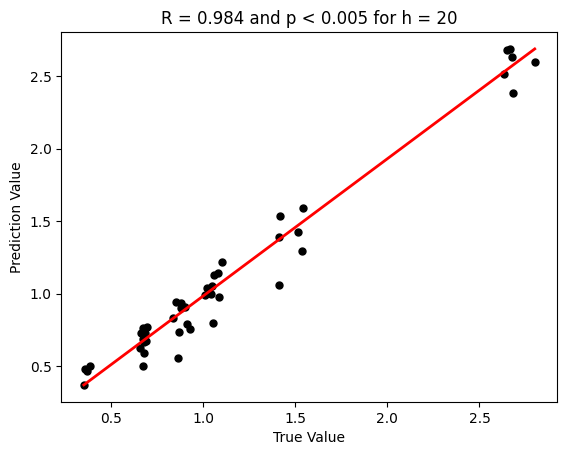

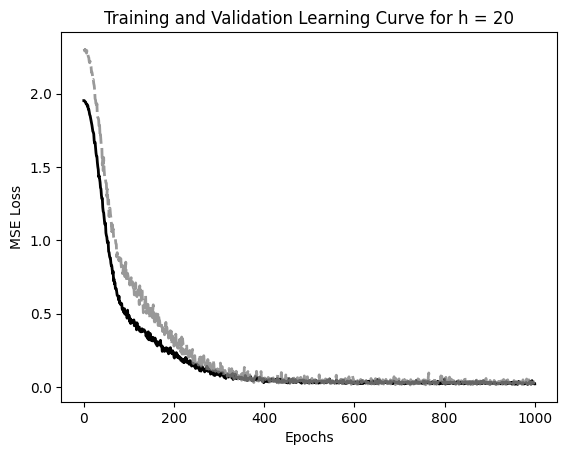

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 20]      [1, 20]     160        140
1_y        [20, 1]       [1, 1]      21         20
--------------------------------------------------
                      Totals
Total params             181
Trainable params         181
Non-trainable params       0
Mult-Adds                160
Epoch: 0 Train Loss: 1.538               Validation Loss: 1.833 Elapsed: 0:00:00.002659s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.476               Validation Loss: 0.729 Elapsed: 0:00:00.002550s
Epoch: 200 Train Loss: 0.311               Validation Loss: 0.390 Elapsed: 0:00:00.001861s
Epoch: 300 Train Loss: 0.105               Validation Loss: 0.126 Elapsed: 0:00:00.001779s
Epoch: 400 Train Loss: 0.069               Validation Loss: 0.102 Elapsed: 0:00:00.001813s
Epoch: 500 Train Loss: 0.052               Validation Loss: 0.128 Elapsed: 0:00:00.001880s
Epoch: 600 Train Loss: 0.046               Validation Loss: 0.044 Elapsed: 0:00:00.001968s
Epoch: 700 Train Loss: 0.041               Validation Loss: 0.106 Elapsed: 0:00:00.001825s
Epoch: 800 Train Loss: 0.047               Validation Loss: 0.069 Elapsed: 0:00:00.003092s
Epoch: 900 Train Loss: 0.038               Validation Loss: 0.046 Elapsed: 0:00:00.008148s
Epoch: 1000 Train Loss: 0.029               Validation Loss: 0.051 Elapsed: 0:00:00.001933s
Test Loss: 0.031
R = 0.965, p < 0.005


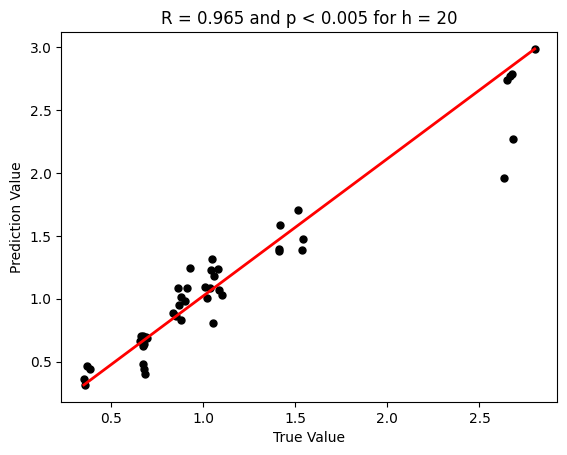

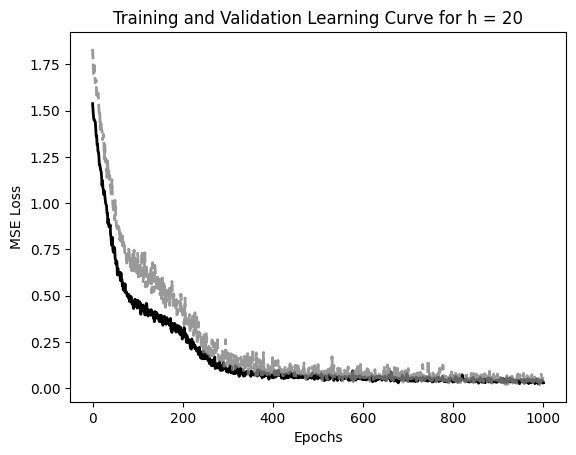

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 30]      [1, 30]     240        210
1_y        [30, 1]       [1, 1]      31         30
--------------------------------------------------
                      Totals
Total params             271
Trainable params         271
Non-trainable params       0
Mult-Adds                240
Epoch: 0 Train Loss: 1.912               Validation Loss: 2.250 Elapsed: 0:00:00.002780s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.381               Validation Loss: 0.524 Elapsed: 0:00:00.001890s
Epoch: 200 Train Loss: 0.185               Validation Loss: 0.260 Elapsed: 0:00:00.001826s
Epoch: 300 Train Loss: 0.064               Validation Loss: 0.089 Elapsed: 0:00:00.002239s
Epoch: 400 Train Loss: 0.027               Validation Loss: 0.032 Elapsed: 0:00:00.001960s
Epoch: 500 Train Loss: 0.016               Validation Loss: 0.021 Elapsed: 0:00:00.001903s
Epoch: 600 Train Loss: 0.015               Validation Loss: 0.019 Elapsed: 0:00:00.001731s
Epoch: 700 Train Loss: 0.020               Validation Loss: 0.032 Elapsed: 0:00:00.001861s
Epoch: 800 Train Loss: 0.021               Validation Loss: 0.031 Elapsed: 0:00:00.001867s
Epoch: 900 Train Loss: 0.019               Validation Loss: 0.009 Elapsed: 0:00:00.001907s
Epoch: 1000 Train Loss: 0.015               Validation Loss: 0.022 Elapsed: 0:00:00.001909s
Test Loss: 0.011
R = 0.991, p < 0.005


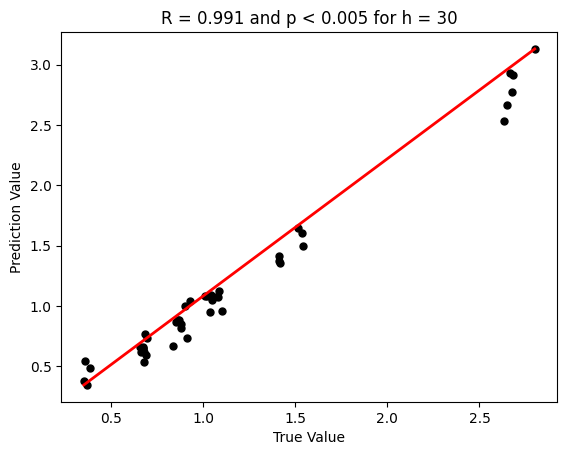

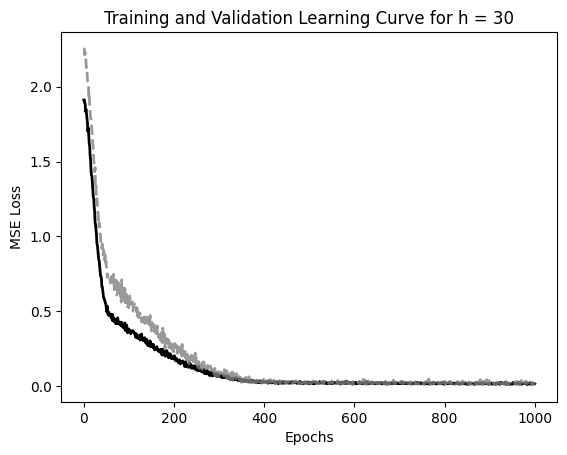

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 30]      [1, 30]     240        210
1_y        [30, 1]       [1, 1]      31         30
--------------------------------------------------
                      Totals
Total params             271
Trainable params         271
Non-trainable params       0
Mult-Adds                240
Epoch: 0 Train Loss: 1.439               Validation Loss: 1.792 Elapsed: 0:00:00.003435s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.487               Validation Loss: 0.746 Elapsed: 0:00:00.001941s
Epoch: 200 Train Loss: 0.258               Validation Loss: 0.334 Elapsed: 0:00:00.002127s
Epoch: 300 Train Loss: 0.105               Validation Loss: 0.109 Elapsed: 0:00:00.001764s
Epoch: 400 Train Loss: 0.034               Validation Loss: 0.044 Elapsed: 0:00:00.001916s
Epoch: 500 Train Loss: 0.032               Validation Loss: 0.055 Elapsed: 0:00:00.001834s
Epoch: 600 Train Loss: 0.021               Validation Loss: 0.029 Elapsed: 0:00:00.001753s
Epoch: 700 Train Loss: 0.022               Validation Loss: 0.039 Elapsed: 0:00:00.001913s
Epoch: 800 Train Loss: 0.019               Validation Loss: 0.013 Elapsed: 0:00:00.001788s
Epoch: 900 Train Loss: 0.013               Validation Loss: 0.019 Elapsed: 0:00:00.002496s
Epoch: 1000 Train Loss: 0.017               Validation Loss: 0.018 Elapsed: 0:00:00.002231s
Test Loss: 0.018
R = 0.980, p < 0.005


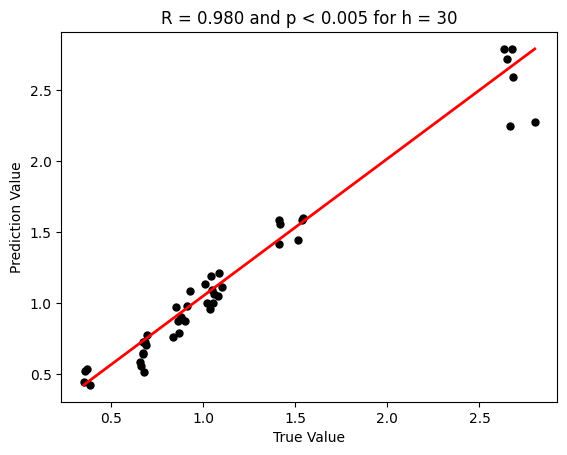

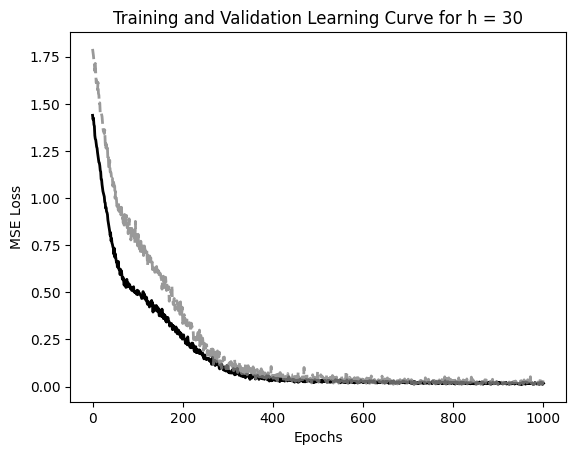

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 30]      [1, 30]     240        210
1_y        [30, 1]       [1, 1]      31         30
--------------------------------------------------
                      Totals
Total params             271
Trainable params         271
Non-trainable params       0
Mult-Adds                240
Epoch: 0 Train Loss: 1.961               Validation Loss: 2.314 Elapsed: 0:00:00.007389s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.528               Validation Loss: 0.800 Elapsed: 0:00:00.002367s
Epoch: 200 Train Loss: 0.324               Validation Loss: 0.434 Elapsed: 0:00:00.002388s
Epoch: 300 Train Loss: 0.132               Validation Loss: 0.177 Elapsed: 0:00:00.002585s
Epoch: 400 Train Loss: 0.062               Validation Loss: 0.076 Elapsed: 0:00:00.005147s
Epoch: 500 Train Loss: 0.040               Validation Loss: 0.075 Elapsed: 0:00:00.002326s
Epoch: 600 Train Loss: 0.034               Validation Loss: 0.076 Elapsed: 0:00:00.002239s
Epoch: 700 Train Loss: 0.030               Validation Loss: 0.033 Elapsed: 0:00:00.002392s
Epoch: 800 Train Loss: 0.024               Validation Loss: 0.025 Elapsed: 0:00:00.001889s
Epoch: 900 Train Loss: 0.025               Validation Loss: 0.028 Elapsed: 0:00:00.001770s
Epoch: 1000 Train Loss: 0.028               Validation Loss: 0.036 Elapsed: 0:00:00.001793s
Test Loss: 0.018
R = 0.982, p < 0.005


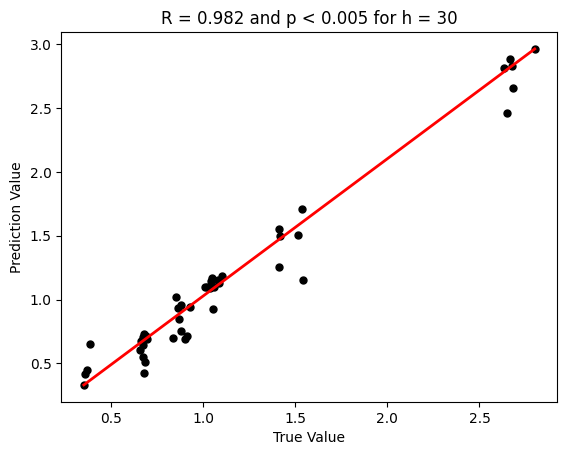

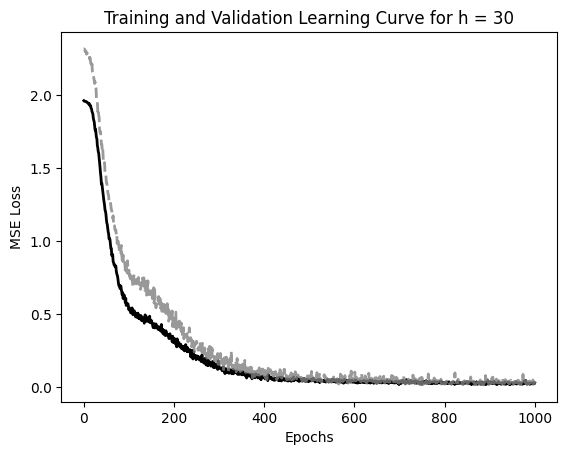

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 30]      [1, 30]     240        210
1_y        [30, 1]       [1, 1]      31         30
--------------------------------------------------
                      Totals
Total params             271
Trainable params         271
Non-trainable params       0
Mult-Adds                240
Epoch: 0 Train Loss: 1.634               Validation Loss: 1.936 Elapsed: 0:00:00.003027s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.417               Validation Loss: 0.604 Elapsed: 0:00:00.002351s
Epoch: 200 Train Loss: 0.247               Validation Loss: 0.280 Elapsed: 0:00:00.001960s
Epoch: 300 Train Loss: 0.113               Validation Loss: 0.128 Elapsed: 0:00:00.002063s
Epoch: 400 Train Loss: 0.051               Validation Loss: 0.048 Elapsed: 0:00:00.001991s
Epoch: 500 Train Loss: 0.041               Validation Loss: 0.030 Elapsed: 0:00:00.001732s
Epoch: 600 Train Loss: 0.027               Validation Loss: 0.028 Elapsed: 0:00:00.002019s
Epoch: 700 Train Loss: 0.024               Validation Loss: 0.023 Elapsed: 0:00:00.001833s
Epoch: 800 Train Loss: 0.028               Validation Loss: 0.058 Elapsed: 0:00:00.002201s
Epoch: 900 Train Loss: 0.023               Validation Loss: 0.023 Elapsed: 0:00:00.001927s
Epoch: 1000 Train Loss: 0.019               Validation Loss: 0.027 Elapsed: 0:00:00.001898s
Test Loss: 0.014
R = 0.986, p < 0.005


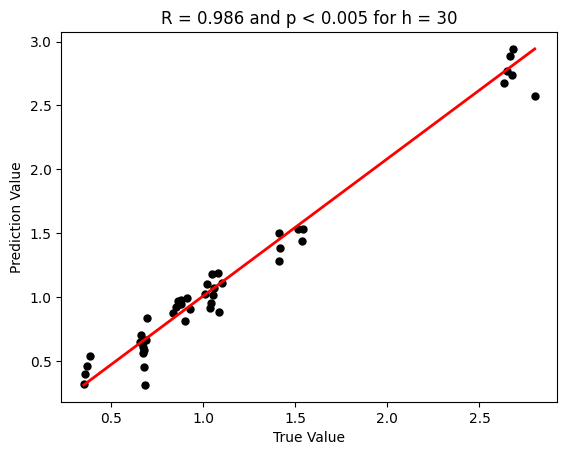

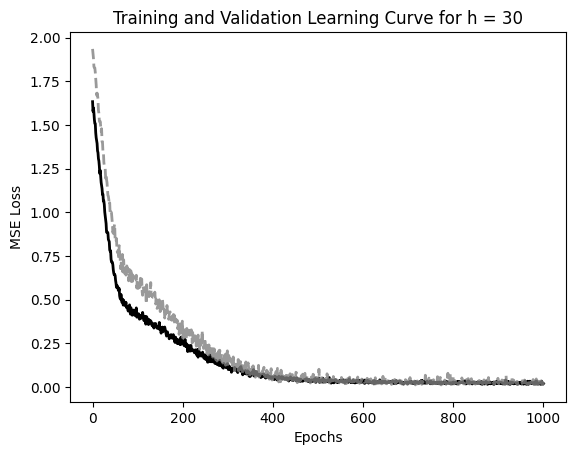

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 30]      [1, 30]     240        210
1_y        [30, 1]       [1, 1]      31         30
--------------------------------------------------
                      Totals
Total params             271
Trainable params         271
Non-trainable params       0
Mult-Adds                240
Epoch: 0 Train Loss: 1.936               Validation Loss: 2.291 Elapsed: 0:00:00.003061s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.515               Validation Loss: 0.791 Elapsed: 0:00:00.002290s
Epoch: 200 Train Loss: 0.303               Validation Loss: 0.397 Elapsed: 0:00:00.001995s
Epoch: 300 Train Loss: 0.102               Validation Loss: 0.166 Elapsed: 0:00:00.002041s
Epoch: 400 Train Loss: 0.054               Validation Loss: 0.073 Elapsed: 0:00:00.002264s
Epoch: 500 Train Loss: 0.034               Validation Loss: 0.058 Elapsed: 0:00:00.003074s
Epoch: 600 Train Loss: 0.031               Validation Loss: 0.049 Elapsed: 0:00:00.001862s
Epoch: 700 Train Loss: 0.027               Validation Loss: 0.016 Elapsed: 0:00:00.002001s
Epoch: 800 Train Loss: 0.026               Validation Loss: 0.060 Elapsed: 0:00:00.002028s
Epoch: 900 Train Loss: 0.025               Validation Loss: 0.035 Elapsed: 0:00:00.001845s
Epoch: 1000 Train Loss: 0.023               Validation Loss: 0.016 Elapsed: 0:00:00.001913s
Test Loss: 0.020
R = 0.978, p < 0.005


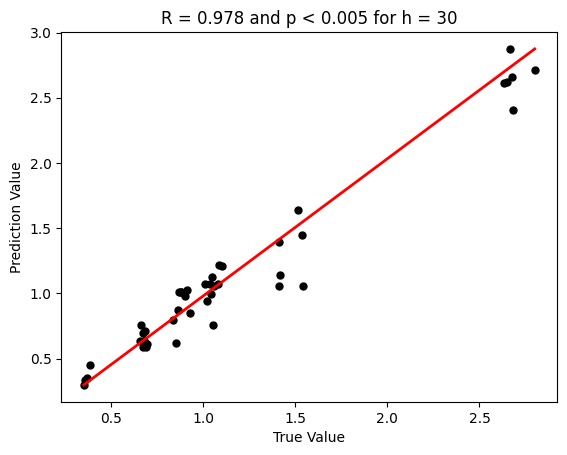

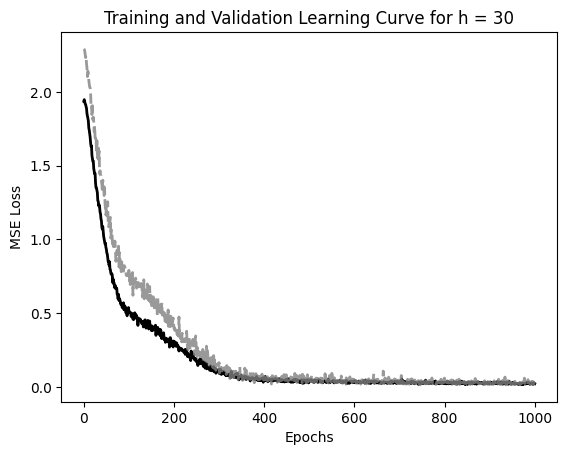

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 40]      [1, 40]     320        280
1_y        [40, 1]       [1, 1]      41         40
--------------------------------------------------
                      Totals
Total params             361
Trainable params         361
Non-trainable params       0
Mult-Adds                320
Epoch: 0 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.003268s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.442               Validation Loss: 0.679 Elapsed: 0:00:00.002308s
Epoch: 200 Train Loss: 0.208               Validation Loss: 0.334 Elapsed: 0:00:00.002030s
Epoch: 300 Train Loss: 0.061               Validation Loss: 0.073 Elapsed: 0:00:00.001918s
Epoch: 400 Train Loss: 0.029               Validation Loss: 0.029 Elapsed: 0:00:00.003493s
Epoch: 500 Train Loss: 0.033               Validation Loss: 0.022 Elapsed: 0:00:00.002000s
Epoch: 600 Train Loss: 0.023               Validation Loss: 0.026 Elapsed: 0:00:00.002053s
Epoch: 700 Train Loss: 0.018               Validation Loss: 0.022 Elapsed: 0:00:00.002675s
Epoch: 800 Train Loss: 0.019               Validation Loss: 0.028 Elapsed: 0:00:00.001767s
Epoch: 900 Train Loss: 0.020               Validation Loss: 0.020 Elapsed: 0:00:00.001769s
Epoch: 1000 Train Loss: 0.021               Validation Loss: 0.015 Elapsed: 0:00:00.001858s
Test Loss: 0.014
R = 0.986, p < 0.005


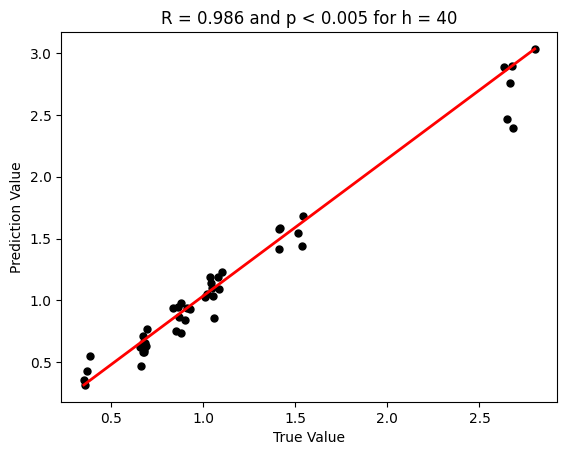

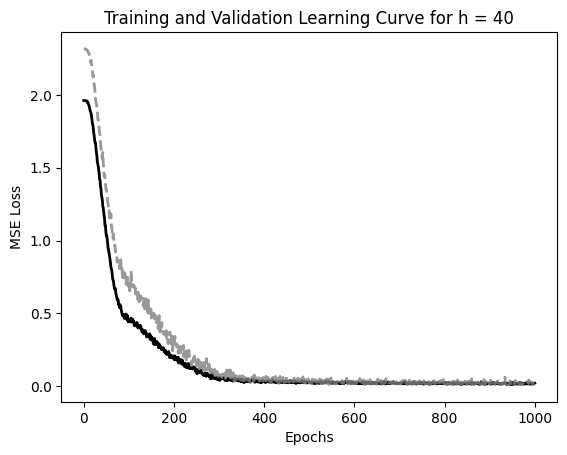

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 40]      [1, 40]     320        280
1_y        [40, 1]       [1, 1]      41         40
--------------------------------------------------
                      Totals
Total params             361
Trainable params         361
Non-trainable params       0
Mult-Adds                320
Epoch: 0 Train Loss: 1.950               Validation Loss: 2.307 Elapsed: 0:00:00.003167s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.468               Validation Loss: 0.695 Elapsed: 0:00:00.002305s
Epoch: 200 Train Loss: 0.208               Validation Loss: 0.311 Elapsed: 0:00:00.002286s
Epoch: 300 Train Loss: 0.065               Validation Loss: 0.077 Elapsed: 0:00:00.003635s
Epoch: 400 Train Loss: 0.031               Validation Loss: 0.064 Elapsed: 0:00:00.002393s
Epoch: 500 Train Loss: 0.032               Validation Loss: 0.035 Elapsed: 0:00:00.002283s
Epoch: 600 Train Loss: 0.027               Validation Loss: 0.032 Elapsed: 0:00:00.002267s
Epoch: 700 Train Loss: 0.028               Validation Loss: 0.033 Elapsed: 0:00:00.002337s
Epoch: 800 Train Loss: 0.025               Validation Loss: 0.044 Elapsed: 0:00:00.002576s
Epoch: 900 Train Loss: 0.018               Validation Loss: 0.031 Elapsed: 0:00:00.002322s
Epoch: 1000 Train Loss: 0.015               Validation Loss: 0.028 Elapsed: 0:00:00.002282s
Test Loss: 0.018
R = 0.981, p < 0.005


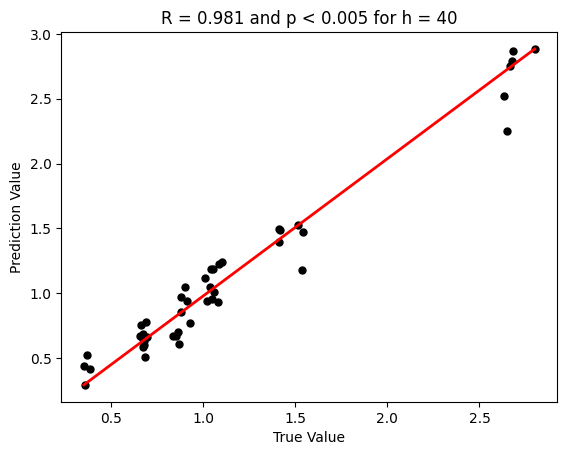

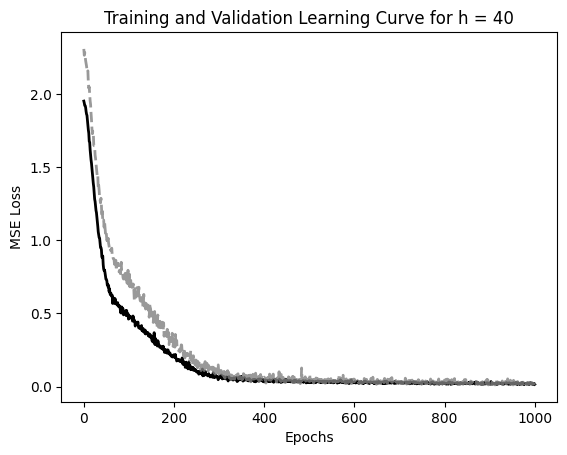

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 40]      [1, 40]     320        280
1_y        [40, 1]       [1, 1]      41         40
--------------------------------------------------
                      Totals
Total params             361
Trainable params         361
Non-trainable params       0
Mult-Adds                320
Epoch: 0 Train Loss: 1.513               Validation Loss: 1.852 Elapsed: 0:00:00.003309s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.477               Validation Loss: 0.746 Elapsed: 0:00:00.002013s
Epoch: 200 Train Loss: 0.165               Validation Loss: 0.207 Elapsed: 0:00:00.001924s
Epoch: 300 Train Loss: 0.050               Validation Loss: 0.082 Elapsed: 0:00:00.001819s
Epoch: 400 Train Loss: 0.049               Validation Loss: 0.049 Elapsed: 0:00:00.001777s
Epoch: 500 Train Loss: 0.033               Validation Loss: 0.030 Elapsed: 0:00:00.001852s
Epoch: 600 Train Loss: 0.026               Validation Loss: 0.025 Elapsed: 0:00:00.001769s
Epoch: 700 Train Loss: 0.018               Validation Loss: 0.025 Elapsed: 0:00:00.001766s
Epoch: 800 Train Loss: 0.018               Validation Loss: 0.021 Elapsed: 0:00:00.001895s
Epoch: 900 Train Loss: 0.015               Validation Loss: 0.011 Elapsed: 0:00:00.001822s
Epoch: 1000 Train Loss: 0.019               Validation Loss: 0.021 Elapsed: 0:00:00.001725s
Test Loss: 0.020
R = 0.980, p < 0.005


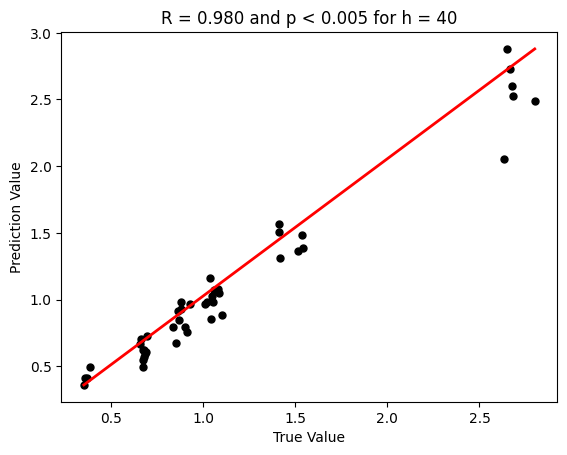

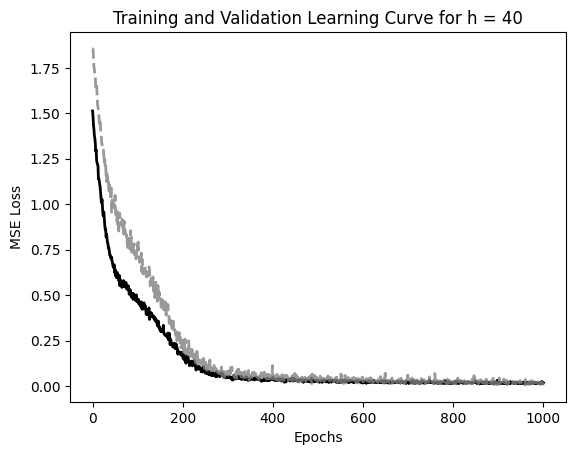

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 40]      [1, 40]     320        280
1_y        [40, 1]       [1, 1]      41         40
--------------------------------------------------
                      Totals
Total params             361
Trainable params         361
Non-trainable params       0
Mult-Adds                320
Epoch: 0 Train Loss: 1.933               Validation Loss: 2.292 Elapsed: 0:00:00.003441s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.338               Validation Loss: 0.526 Elapsed: 0:00:00.002189s
Epoch: 200 Train Loss: 0.095               Validation Loss: 0.113 Elapsed: 0:00:00.001845s
Epoch: 300 Train Loss: 0.027               Validation Loss: 0.034 Elapsed: 0:00:00.001909s
Epoch: 400 Train Loss: 0.019               Validation Loss: 0.029 Elapsed: 0:00:00.001940s
Epoch: 500 Train Loss: 0.023               Validation Loss: 0.018 Elapsed: 0:00:00.001880s
Epoch: 600 Train Loss: 0.016               Validation Loss: 0.027 Elapsed: 0:00:00.001871s
Epoch: 700 Train Loss: 0.015               Validation Loss: 0.020 Elapsed: 0:00:00.003273s
Epoch: 800 Train Loss: 0.015               Validation Loss: 0.015 Elapsed: 0:00:00.002604s
Epoch: 900 Train Loss: 0.012               Validation Loss: 0.020 Elapsed: 0:00:00.002472s
Epoch: 1000 Train Loss: 0.014               Validation Loss: 0.014 Elapsed: 0:00:00.001924s
Test Loss: 0.007
R = 0.993, p < 0.005


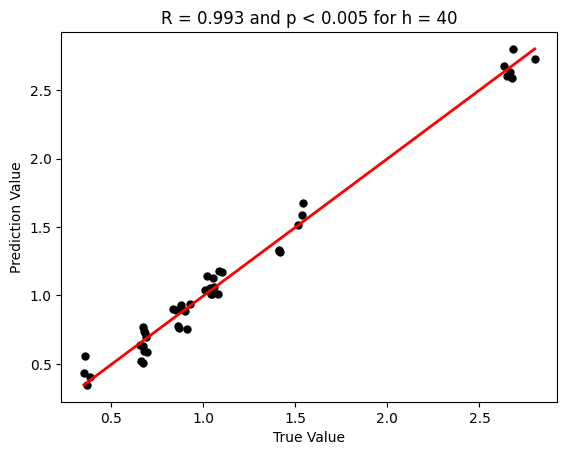

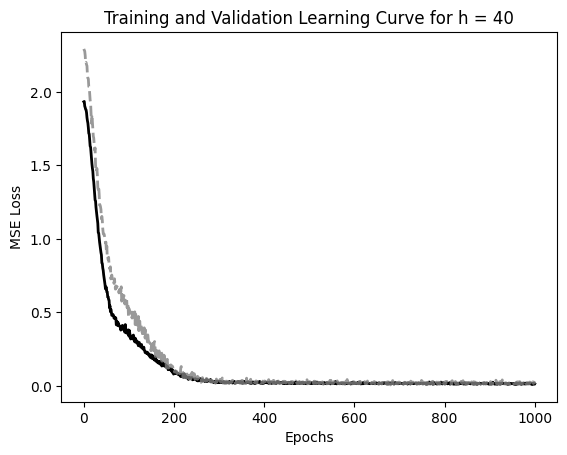

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 40]      [1, 40]     320        280
1_y        [40, 1]       [1, 1]      41         40
--------------------------------------------------
                      Totals
Total params             361
Trainable params         361
Non-trainable params       0
Mult-Adds                320
Epoch: 0 Train Loss: 1.566               Validation Loss: 1.840 Elapsed: 0:00:00.003399s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.484               Validation Loss: 0.629 Elapsed: 0:00:00.002750s
Epoch: 200 Train Loss: 0.186               Validation Loss: 0.252 Elapsed: 0:00:00.002409s
Epoch: 300 Train Loss: 0.055               Validation Loss: 0.079 Elapsed: 0:00:00.002560s
Epoch: 400 Train Loss: 0.034               Validation Loss: 0.034 Elapsed: 0:00:00.002368s
Epoch: 500 Train Loss: 0.024               Validation Loss: 0.029 Elapsed: 0:00:00.002392s
Epoch: 600 Train Loss: 0.021               Validation Loss: 0.020 Elapsed: 0:00:00.001994s
Epoch: 700 Train Loss: 0.029               Validation Loss: 0.033 Elapsed: 0:00:00.001896s
Epoch: 800 Train Loss: 0.013               Validation Loss: 0.016 Elapsed: 0:00:00.001882s
Epoch: 900 Train Loss: 0.014               Validation Loss: 0.019 Elapsed: 0:00:00.001889s
Epoch: 1000 Train Loss: 0.014               Validation Loss: 0.023 Elapsed: 0:00:00.001828s
Test Loss: 0.009
R = 0.991, p < 0.005


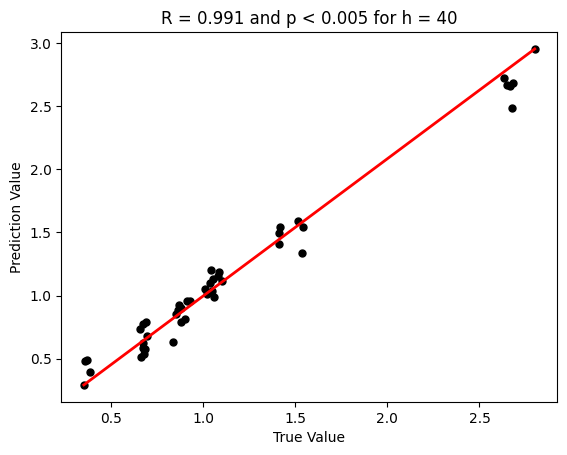

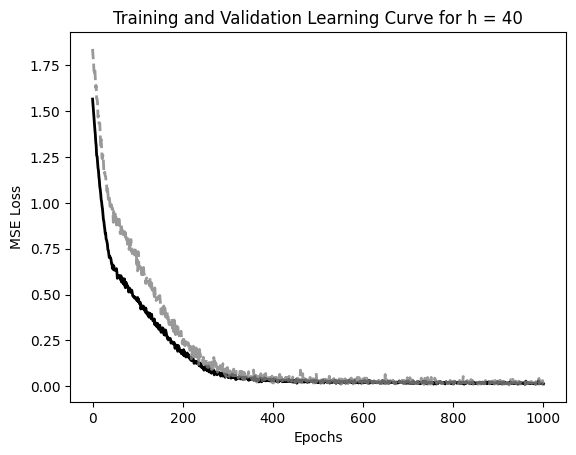

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 50]      [1, 50]     400        350
1_y        [50, 1]       [1, 1]      51         50
--------------------------------------------------
                      Totals
Total params             451
Trainable params         451
Non-trainable params       0
Mult-Adds                400
Epoch: 0 Train Loss: 1.779               Validation Loss: 2.109 Elapsed: 0:00:00.004755s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.332               Validation Loss: 0.447 Elapsed: 0:00:00.002371s
Epoch: 200 Train Loss: 0.118               Validation Loss: 0.163 Elapsed: 0:00:00.002497s
Epoch: 300 Train Loss: 0.030               Validation Loss: 0.039 Elapsed: 0:00:00.002537s
Epoch: 400 Train Loss: 0.031               Validation Loss: 0.071 Elapsed: 0:00:00.003132s
Epoch: 500 Train Loss: 0.019               Validation Loss: 0.027 Elapsed: 0:00:00.002430s
Epoch: 600 Train Loss: 0.016               Validation Loss: 0.028 Elapsed: 0:00:00.002510s
Epoch: 700 Train Loss: 0.014               Validation Loss: 0.017 Elapsed: 0:00:00.002473s
Epoch: 800 Train Loss: 0.012               Validation Loss: 0.013 Elapsed: 0:00:00.002188s
Epoch: 900 Train Loss: 0.013               Validation Loss: 0.013 Elapsed: 0:00:00.002354s
Epoch: 1000 Train Loss: 0.013               Validation Loss: 0.013 Elapsed: 0:00:00.002333s
Test Loss: 0.013
R = 0.986, p < 0.005


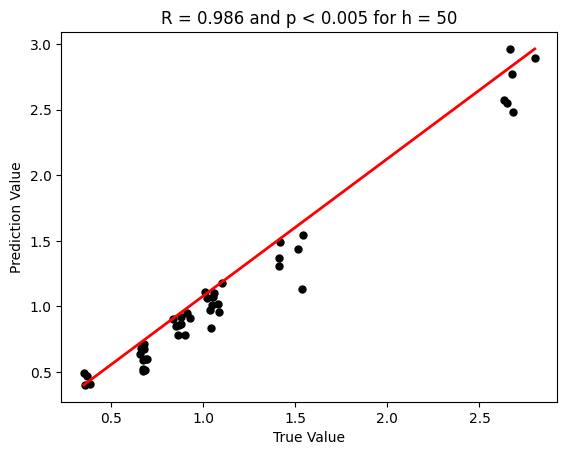

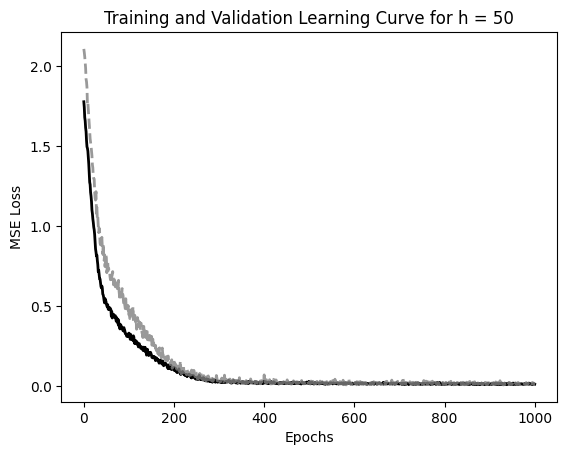

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 50]      [1, 50]     400        350
1_y        [50, 1]       [1, 1]      51         50
--------------------------------------------------
                      Totals
Total params             451
Trainable params         451
Non-trainable params       0
Mult-Adds                400
Epoch: 0 Train Loss: 1.855               Validation Loss: 2.147 Elapsed: 0:00:00.006494s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.316               Validation Loss: 0.462 Elapsed: 0:00:00.002202s
Epoch: 200 Train Loss: 0.086               Validation Loss: 0.130 Elapsed: 0:00:00.001936s
Epoch: 300 Train Loss: 0.026               Validation Loss: 0.024 Elapsed: 0:00:00.001902s
Epoch: 400 Train Loss: 0.018               Validation Loss: 0.020 Elapsed: 0:00:00.001955s
Epoch: 500 Train Loss: 0.020               Validation Loss: 0.019 Elapsed: 0:00:00.001781s
Epoch: 600 Train Loss: 0.016               Validation Loss: 0.020 Elapsed: 0:00:00.001845s
Epoch: 700 Train Loss: 0.014               Validation Loss: 0.022 Elapsed: 0:00:00.001797s
Epoch: 800 Train Loss: 0.012               Validation Loss: 0.030 Elapsed: 0:00:00.001761s
Epoch: 900 Train Loss: 0.012               Validation Loss: 0.012 Elapsed: 0:00:00.001915s
Epoch: 1000 Train Loss: 0.012               Validation Loss: 0.027 Elapsed: 0:00:00.001932s
Test Loss: 0.007
R = 0.993, p < 0.005


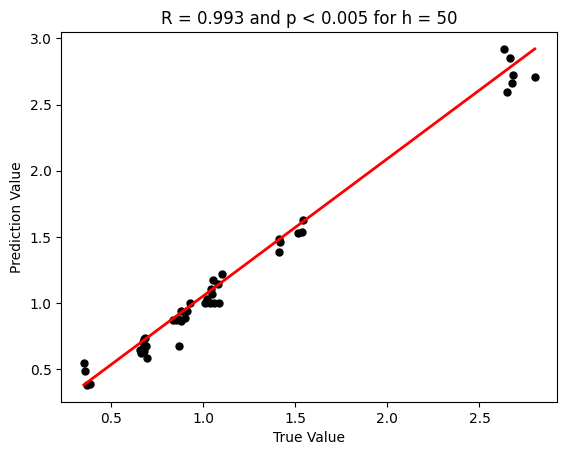

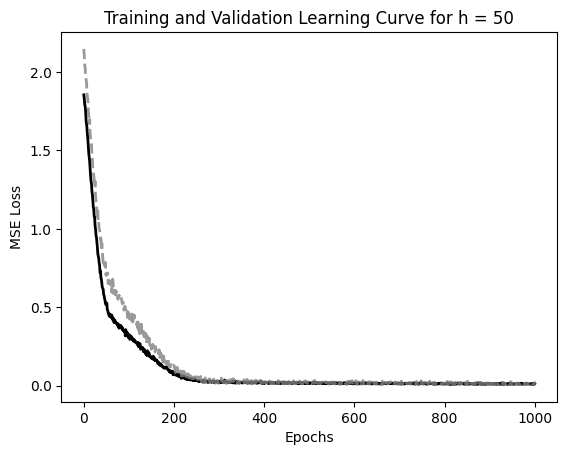

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 50]      [1, 50]     400        350
1_y        [50, 1]       [1, 1]      51         50
--------------------------------------------------
                      Totals
Total params             451
Trainable params         451
Non-trainable params       0
Mult-Adds                400
Epoch: 0 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002987s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 1.961               Validation Loss: 2.315 Elapsed: 0:00:00.002150s
Epoch: 200 Train Loss: 0.308               Validation Loss: 0.432 Elapsed: 0:00:00.001765s
Epoch: 300 Train Loss: 0.048               Validation Loss: 0.045 Elapsed: 0:00:00.001808s
Epoch: 400 Train Loss: 0.018               Validation Loss: 0.021 Elapsed: 0:00:00.001844s
Epoch: 500 Train Loss: 0.017               Validation Loss: 0.018 Elapsed: 0:00:00.001776s
Epoch: 600 Train Loss: 0.017               Validation Loss: 0.016 Elapsed: 0:00:00.001817s
Epoch: 700 Train Loss: 0.014               Validation Loss: 0.017 Elapsed: 0:00:00.001898s
Epoch: 800 Train Loss: 0.013               Validation Loss: 0.013 Elapsed: 0:00:00.001790s
Epoch: 900 Train Loss: 0.011               Validation Loss: 0.012 Elapsed: 0:00:00.001958s
Epoch: 1000 Train Loss: 0.016               Validation Loss: 0.017 Elapsed: 0:00:00.002012s
Test Loss: 0.009
R = 0.990, p < 0.005


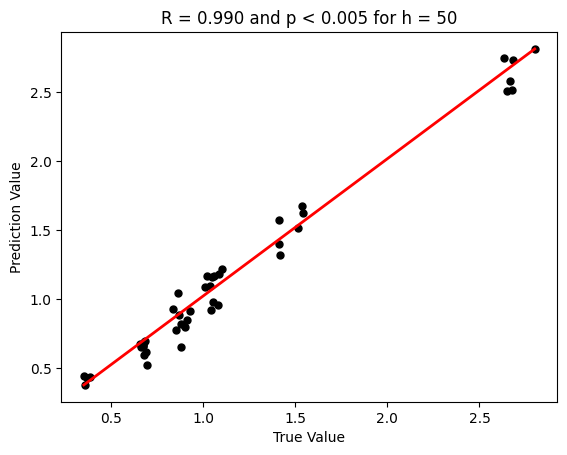

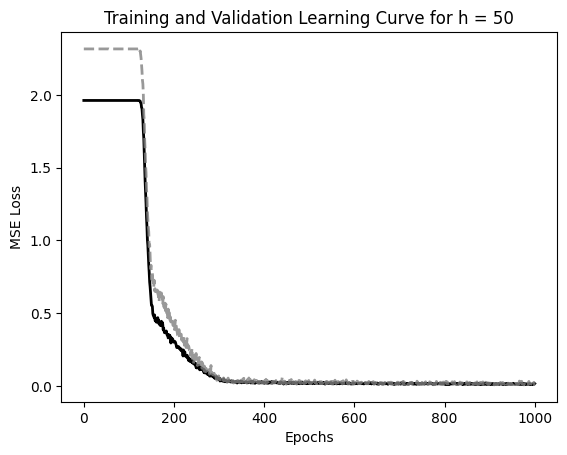

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 50]      [1, 50]     400        350
1_y        [50, 1]       [1, 1]      51         50
--------------------------------------------------
                      Totals
Total params             451
Trainable params         451
Non-trainable params       0
Mult-Adds                400
Epoch: 0 Train Loss: 1.960               Validation Loss: 2.311 Elapsed: 0:00:00.003418s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.462               Validation Loss: 0.681 Elapsed: 0:00:00.001981s
Epoch: 200 Train Loss: 0.155               Validation Loss: 0.211 Elapsed: 0:00:00.001843s
Epoch: 300 Train Loss: 0.042               Validation Loss: 0.038 Elapsed: 0:00:00.001889s
Epoch: 400 Train Loss: 0.030               Validation Loss: 0.027 Elapsed: 0:00:00.001844s
Epoch: 500 Train Loss: 0.024               Validation Loss: 0.031 Elapsed: 0:00:00.002100s
Epoch: 600 Train Loss: 0.025               Validation Loss: 0.033 Elapsed: 0:00:00.002037s
Epoch: 700 Train Loss: 0.023               Validation Loss: 0.044 Elapsed: 0:00:00.001885s
Epoch: 800 Train Loss: 0.020               Validation Loss: 0.026 Elapsed: 0:00:00.001914s
Epoch: 900 Train Loss: 0.018               Validation Loss: 0.017 Elapsed: 0:00:00.001815s
Epoch: 1000 Train Loss: 0.013               Validation Loss: 0.020 Elapsed: 0:00:00.001882s
Test Loss: 0.010
R = 0.992, p < 0.005


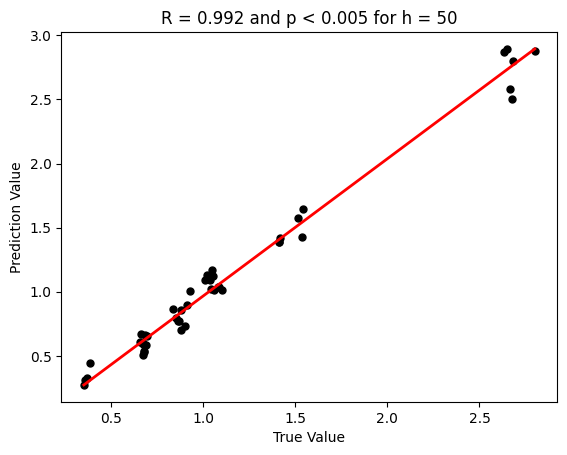

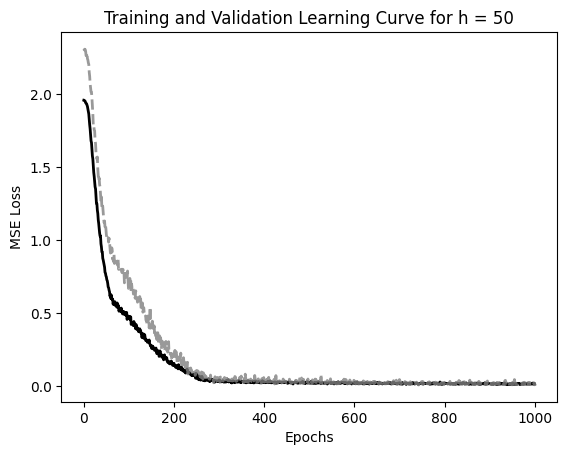

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 50]      [1, 50]     400        350
1_y        [50, 1]       [1, 1]      51         50
--------------------------------------------------
                      Totals
Total params             451
Trainable params         451
Non-trainable params       0
Mult-Adds                400
Epoch: 0 Train Loss: 1.867               Validation Loss: 2.182 Elapsed: 0:00:00.003549s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.465               Validation Loss: 0.676 Elapsed: 0:00:00.002377s
Epoch: 200 Train Loss: 0.168               Validation Loss: 0.239 Elapsed: 0:00:00.004511s
Epoch: 300 Train Loss: 0.029               Validation Loss: 0.052 Elapsed: 0:00:00.002240s
Epoch: 400 Train Loss: 0.022               Validation Loss: 0.021 Elapsed: 0:00:00.001837s
Epoch: 500 Train Loss: 0.014               Validation Loss: 0.020 Elapsed: 0:00:00.001909s
Epoch: 600 Train Loss: 0.015               Validation Loss: 0.018 Elapsed: 0:00:00.001877s
Epoch: 700 Train Loss: 0.015               Validation Loss: 0.017 Elapsed: 0:00:00.002442s
Epoch: 800 Train Loss: 0.011               Validation Loss: 0.018 Elapsed: 0:00:00.003424s
Epoch: 900 Train Loss: 0.013               Validation Loss: 0.019 Elapsed: 0:00:00.002579s
Epoch: 1000 Train Loss: 0.010               Validation Loss: 0.012 Elapsed: 0:00:00.002766s
Test Loss: 0.011
R = 0.988, p < 0.005


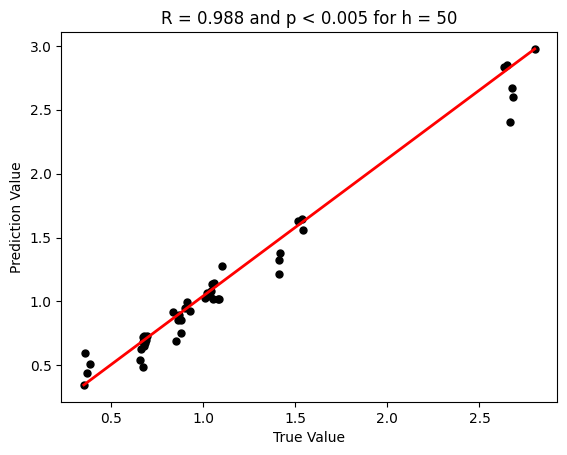

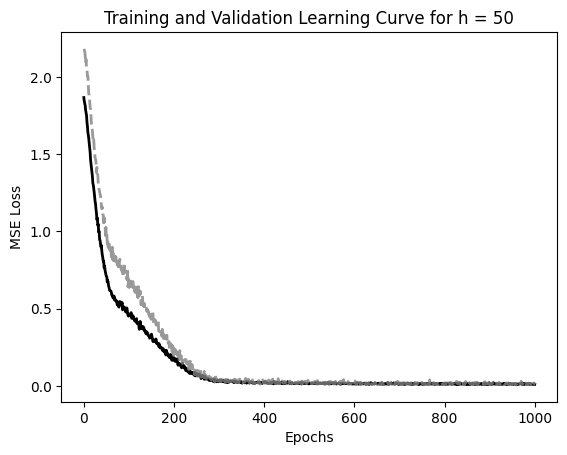

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 60]      [1, 60]     480        420
1_y        [60, 1]       [1, 1]      61         60
--------------------------------------------------
                      Totals
Total params             541
Trainable params         541
Non-trainable params       0
Mult-Adds                480
Epoch: 0 Train Loss: 1.916               Validation Loss: 2.238 Elapsed: 0:00:00.003310s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.381               Validation Loss: 0.570 Elapsed: 0:00:00.002327s
Epoch: 200 Train Loss: 0.087               Validation Loss: 0.173 Elapsed: 0:00:00.002251s
Epoch: 300 Train Loss: 0.047               Validation Loss: 0.047 Elapsed: 0:00:00.002238s
Epoch: 400 Train Loss: 0.035               Validation Loss: 0.049 Elapsed: 0:00:00.002172s
Epoch: 500 Train Loss: 0.024               Validation Loss: 0.037 Elapsed: 0:00:00.002448s
Epoch: 600 Train Loss: 0.023               Validation Loss: 0.028 Elapsed: 0:00:00.002367s
Epoch: 700 Train Loss: 0.018               Validation Loss: 0.018 Elapsed: 0:00:00.001870s
Epoch: 800 Train Loss: 0.021               Validation Loss: 0.023 Elapsed: 0:00:00.001939s
Epoch: 900 Train Loss: 0.016               Validation Loss: 0.018 Elapsed: 0:00:00.001882s
Epoch: 1000 Train Loss: 0.015               Validation Loss: 0.017 Elapsed: 0:00:00.001885s
Test Loss: 0.011
R = 0.988, p < 0.005


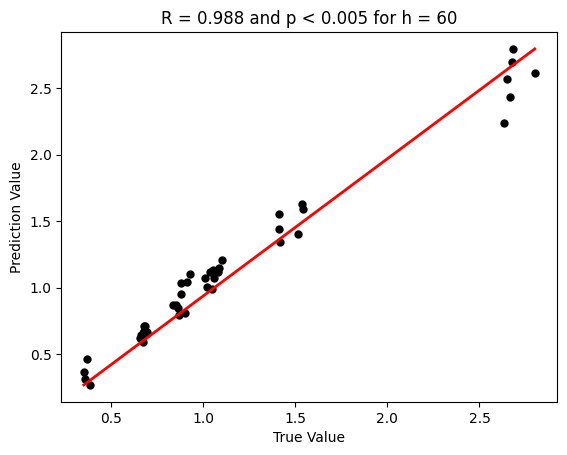

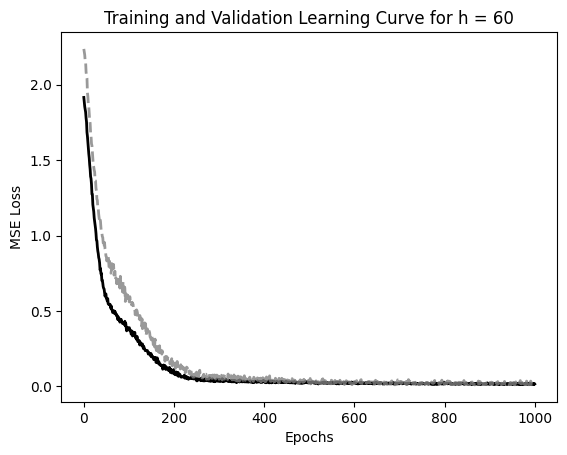

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 60]      [1, 60]     480        420
1_y        [60, 1]       [1, 1]      61         60
--------------------------------------------------
                      Totals
Total params             541
Trainable params         541
Non-trainable params       0
Mult-Adds                480
Epoch: 0 Train Loss: 1.906               Validation Loss: 2.233 Elapsed: 0:00:00.003096s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.361               Validation Loss: 0.597 Elapsed: 0:00:00.002547s
Epoch: 200 Train Loss: 0.076               Validation Loss: 0.088 Elapsed: 0:00:00.002562s
Epoch: 300 Train Loss: 0.027               Validation Loss: 0.027 Elapsed: 0:00:00.001858s
Epoch: 400 Train Loss: 0.019               Validation Loss: 0.023 Elapsed: 0:00:00.001819s
Epoch: 500 Train Loss: 0.019               Validation Loss: 0.013 Elapsed: 0:00:00.002643s
Epoch: 600 Train Loss: 0.012               Validation Loss: 0.014 Elapsed: 0:00:00.001940s
Epoch: 700 Train Loss: 0.017               Validation Loss: 0.014 Elapsed: 0:00:00.001829s
Epoch: 800 Train Loss: 0.014               Validation Loss: 0.008 Elapsed: 0:00:00.002056s
Epoch: 900 Train Loss: 0.011               Validation Loss: 0.017 Elapsed: 0:00:00.001791s
Epoch: 1000 Train Loss: 0.009               Validation Loss: 0.017 Elapsed: 0:00:00.001916s
Test Loss: 0.016
R = 0.984, p < 0.005


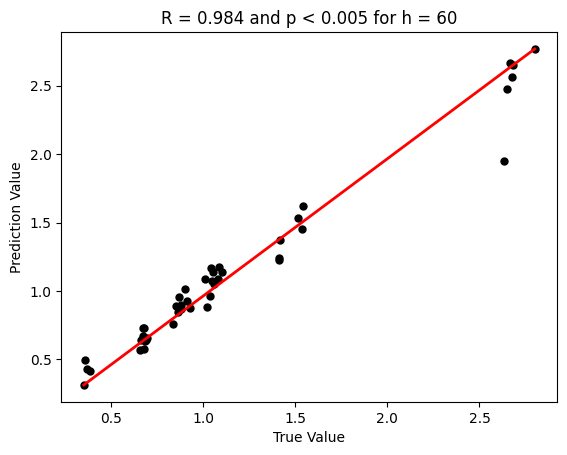

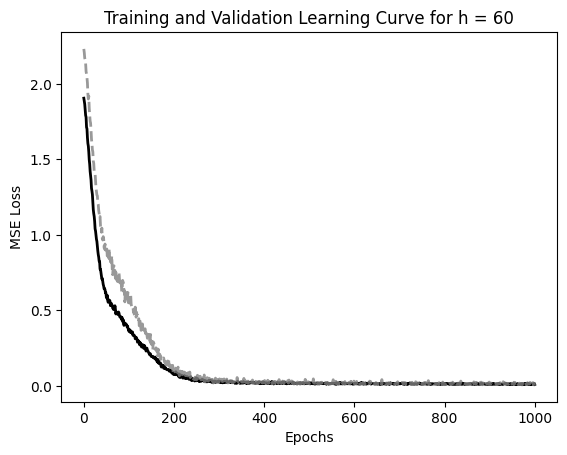

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 60]      [1, 60]     480        420
1_y        [60, 1]       [1, 1]      61         60
--------------------------------------------------
                      Totals
Total params             541
Trainable params         541
Non-trainable params       0
Mult-Adds                480
Epoch: 0 Train Loss: 1.897               Validation Loss: 2.186 Elapsed: 0:00:00.003038s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.332               Validation Loss: 0.500 Elapsed: 0:00:00.002338s
Epoch: 200 Train Loss: 0.068               Validation Loss: 0.102 Elapsed: 0:00:00.002733s
Epoch: 300 Train Loss: 0.031               Validation Loss: 0.037 Elapsed: 0:00:00.001775s
Epoch: 400 Train Loss: 0.024               Validation Loss: 0.019 Elapsed: 0:00:00.001919s
Epoch: 500 Train Loss: 0.018               Validation Loss: 0.029 Elapsed: 0:00:00.001812s
Epoch: 600 Train Loss: 0.025               Validation Loss: 0.028 Elapsed: 0:00:00.001759s
Epoch: 700 Train Loss: 0.021               Validation Loss: 0.030 Elapsed: 0:00:00.002310s
Epoch: 800 Train Loss: 0.012               Validation Loss: 0.019 Elapsed: 0:00:00.006500s
Epoch: 900 Train Loss: 0.014               Validation Loss: 0.017 Elapsed: 0:00:00.001831s
Epoch: 1000 Train Loss: 0.010               Validation Loss: 0.019 Elapsed: 0:00:00.001922s
Test Loss: 0.012
R = 0.987, p < 0.005


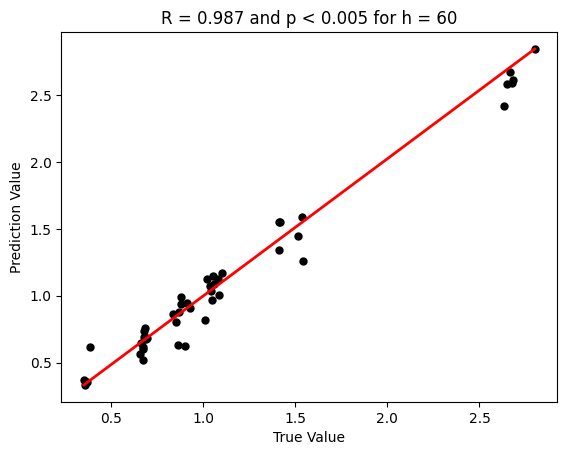

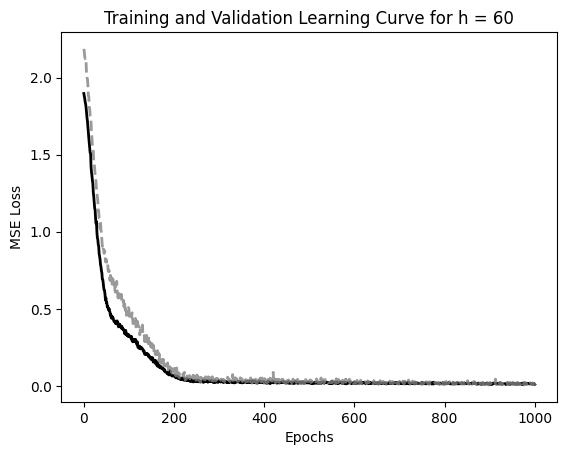

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 60]      [1, 60]     480        420
1_y        [60, 1]       [1, 1]      61         60
--------------------------------------------------
                      Totals
Total params             541
Trainable params         541
Non-trainable params       0
Mult-Adds                480
Epoch: 0 Train Loss: 1.944               Validation Loss: 2.298 Elapsed: 0:00:00.003221s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.397               Validation Loss: 0.533 Elapsed: 0:00:00.002209s
Epoch: 200 Train Loss: 0.088               Validation Loss: 0.117 Elapsed: 0:00:00.002396s
Epoch: 300 Train Loss: 0.032               Validation Loss: 0.038 Elapsed: 0:00:00.001888s
Epoch: 400 Train Loss: 0.022               Validation Loss: 0.034 Elapsed: 0:00:00.001930s
Epoch: 500 Train Loss: 0.021               Validation Loss: 0.029 Elapsed: 0:00:00.001963s
Epoch: 600 Train Loss: 0.020               Validation Loss: 0.016 Elapsed: 0:00:00.001811s
Epoch: 700 Train Loss: 0.014               Validation Loss: 0.018 Elapsed: 0:00:00.001876s
Epoch: 800 Train Loss: 0.014               Validation Loss: 0.024 Elapsed: 0:00:00.001953s
Epoch: 900 Train Loss: 0.010               Validation Loss: 0.018 Elapsed: 0:00:00.012147s
Epoch: 1000 Train Loss: 0.011               Validation Loss: 0.022 Elapsed: 0:00:00.001825s
Test Loss: 0.011
R = 0.990, p < 0.005


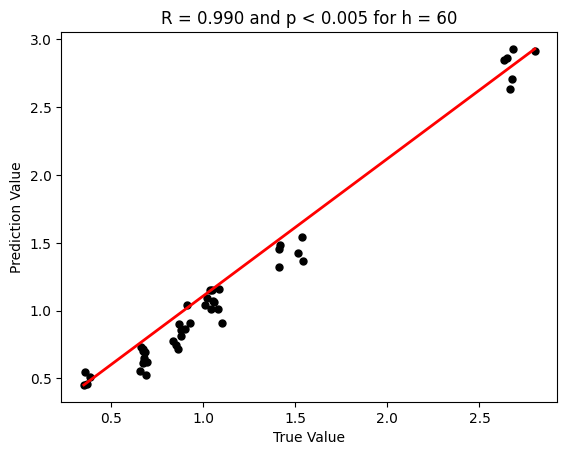

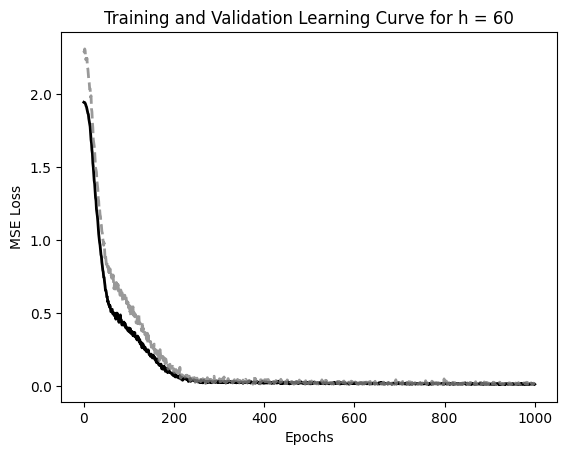

cuda
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 60]      [1, 60]     480        420
1_y        [60, 1]       [1, 1]      61         60
--------------------------------------------------
                      Totals
Total params             541
Trainable params         541
Non-trainable params       0
Mult-Adds                480
Epoch: 0 Train Loss: 1.807               Validation Loss: 2.151 Elapsed: 0:00:00.005552s


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


Epoch: 100 Train Loss: 0.388               Validation Loss: 0.627 Elapsed: 0:00:00.002492s
Epoch: 200 Train Loss: 0.132               Validation Loss: 0.212 Elapsed: 0:00:00.002238s
Epoch: 300 Train Loss: 0.027               Validation Loss: 0.042 Elapsed: 0:00:00.002539s
Epoch: 400 Train Loss: 0.025               Validation Loss: 0.044 Elapsed: 0:00:00.002438s
Epoch: 500 Train Loss: 0.018               Validation Loss: 0.039 Elapsed: 0:00:00.005364s
Epoch: 600 Train Loss: 0.019               Validation Loss: 0.022 Elapsed: 0:00:00.001864s
Epoch: 700 Train Loss: 0.014               Validation Loss: 0.034 Elapsed: 0:00:00.001868s
Epoch: 800 Train Loss: 0.012               Validation Loss: 0.021 Elapsed: 0:00:00.001824s
Epoch: 900 Train Loss: 0.013               Validation Loss: 0.014 Elapsed: 0:00:00.001783s
Epoch: 1000 Train Loss: 0.012               Validation Loss: 0.011 Elapsed: 0:00:00.001935s
Test Loss: 0.019
R = 0.981, p < 0.005


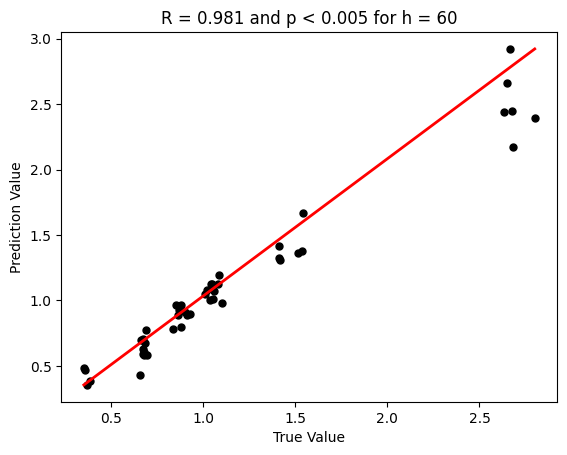

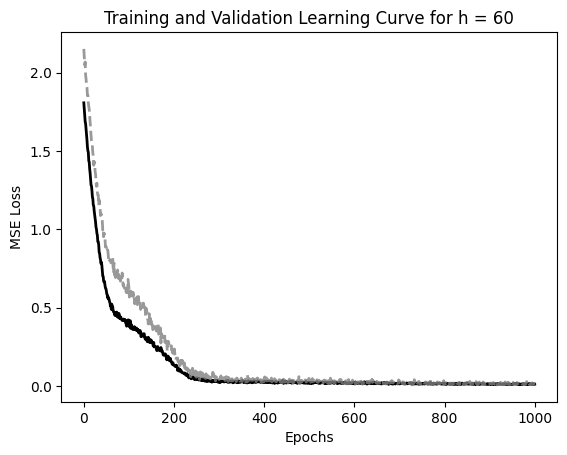

In [ ]:
losses = []
models = []
for h in [10, 20, 30, 40, 50, 60]:
  loss_bundle = []
  model_bundle = []
  for id in range(5):
    model, loss = training_loop(hidden_size=h,
                                Xtrain = Xtrain,
                                ytrain = ytrain,
                                Xtest = Xtest,
                                ytest = ytest,
                                Xval = Xval,
                                yval = yval,
                                id = id + 1)
    model_bundle.append(model)
    loss_bundle.append(loss)

  losses.append(np.mean(loss_bundle))
  best = np.argmin(loss_bundle)
  models.append(model_bundle[best])

best_of_the_best = np.argmin(losses)
bestModel = models[best_of_the_best]

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Best Model Summary')
summary(bestModel, torch.zeros((1,7), device = device))
print(f'Best model was h = {bestModel.M} with loss = {losses[best_of_the_best]:.3f}')
torch.save(bestModel.state_dict(), 'best_model.pt')

Best Model Summary
      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_h        [7, 50]      [1, 50]     400        350
1_y        [50, 1]       [1, 1]      51         50
--------------------------------------------------
                      Totals
Total params             451
Trainable params         451
Non-trainable params       0
Mult-Adds                400
Best model was h = 50 with loss = 0.010


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [ ]:
!zip -r /content/all_files.zip /content